In [29]:
import cartopy
import cartopy.crs as ccrs
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import momepy
from shapely.geometry import LineString

In [48]:
df_grid = pd.read_excel('./grid.xlsx', index_col=0)
df_substations = pd.read_excel('./substations.xlsx', index_col=0)
df_powerplants = pd.read_excel('./power_plants.xlsx', index_col=0)

gdf_substations = gpd.GeoDataFrame(
    df_substations, geometry=gpd.points_from_xy(df_substations.lon, df_substations.lat))

for index, row in gdf_substations.iterrows():
    aggregated_capacity = df_powerplants[df_powerplants.node == index]['capacity'].agg('sum')
    gdf_substations.loc[index, 'aggregated_capacity'] = aggregated_capacity

In [49]:
for index, row in df_grid.iterrows():
    df_grid.loc[index, 'start_lon'] = df_substations.loc[row.substation_1, 'lon']
    df_grid.loc[index, 'start_lat'] = df_substations.loc[row.substation_1, 'lat']
    
    df_grid.loc[index, 'end_lon'] = df_substations.loc[row.substation_2, 'lon']
    df_grid.loc[index, 'end_lat'] = df_substations.loc[row.substation_2, 'lat']
    
gdf_grid = gpd.GeoDataFrame(
    df_grid, geometry=gpd.points_from_xy(df_grid.start_lon, df_grid.start_lat))

for index, row in gdf_grid.iterrows():
    gdf_grid.loc[index, 'geometry'] = LineString([(row.start_lon, row.start_lat), (row.end_lon, row.end_lat)])
    
gdf_grid = gdf_grid.drop(columns=['substation_1', 'substation_2', 'start_lon', 'end_lon', 'start_lat', 'end_lat'])
gdf_substations = gdf_substations.drop(columns=['lon', 'lat'])

In [50]:
gdf_network = pd.concat([gdf_substations, gdf_grid])
display(gdf_network)

C:\Users\balaz\SoftwareDeveloping\TUD\thesis\FBMC\fbmc_env2\lib\site-packages\IPython\lib\pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
C:\Users\balaz\SoftwareDeveloping\TUD\thesis\FBMC\fbmc_env2\lib\site-packages\IPython\core\formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,name,zone,tso,geometry,aggregated_capacity,eic,voltage,resistance,reactance,susceptance,length,tieline
0,JOACHIMOW,PL,PSE,POINT (19.31664 50.76003),0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TUILIERES,FR,RTE,POINT (0.63585 44.84446),21.634357,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GDANSK,PL,PSE,POINT (18.70968 54.33868),172.160091,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MITRY-MORY (E.D.F.),FR,RTE,POINT (2.63144 48.96713),0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gohrpunkt,DE,Amprion GmbH,POINT (6.70976 51.09093),0.075000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2847,Buers - Westtirol rt (422),DE,TRANSNETBW,"LINESTRING (9.81092 47.14265, 10.87394 47.24442)",NaN,10T-AT-DE-000053,400.0,0.990,14.270,168.7035,91.40,True
2848,Buers - Westtirol ws (421),DE,TRANSNETBW,"LINESTRING (9.81092 47.14265, 10.87394 47.24442)",NaN,10T-AT-DE-000061,220.0,1.000,14.365,170.1173,92.00,True
2849,Buers - Y-Werben,DE,TRANSNETBW,"LINESTRING (9.81092 47.14265, 9.71675 47.43267)",NaN,11T-D4-D7-00001W,220.0,0.595,90.800,70.41881,47.00,True
2850,Eichstetten - Muhlbach rt (Ill),DE,TRANSNETBW,"LINESTRING (7.75350 48.09936, 7.55592 47.90735)",NaN,10T-DE-FR-00002G,400.0,0.380,4.100,70.34027,17.38,True


In [16]:
edgelist = []
for index, row in df_grid.iterrows():
    edgelist.append((row.substation_1, row.substation_2))

Grid = nx.Graph(edgelist)

positions = {}
node_attributes = {}
edge_attributes = {}

for index, row in df_substations.iterrows():
    positions[index] = (row.lon, row.lat)
    node_attributes[index] = {
        "zone": row.zone
    }
    
for index, row in df_substations.iterrows():
    positions[index] = (row.lon, row.lat)
    node_attributes[index] = {
        "zone": row.zone
    }
    
nx.set_node_attributes(Grid, node_attributes)

C:\Users\balaz\SoftwareDeveloping\TUD\thesis\FBMC\fbmc_env2\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


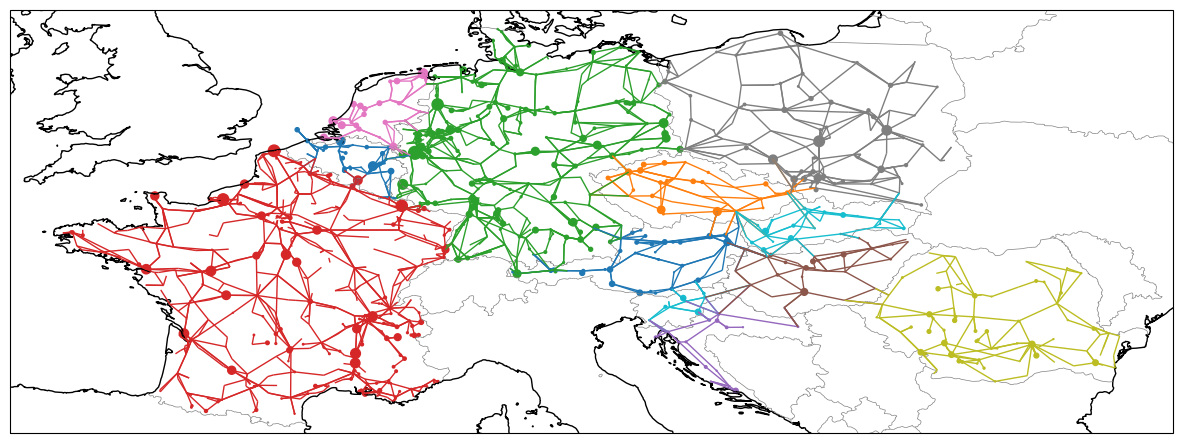

In [53]:
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree())

gdf_network.plot(
    ax=ax,
    column='zone',
    markersize=gdf_network.aggregated_capacity/0.8e2,
    linewidth=1
)

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color='grey', linewidth=0.5)

In [18]:
#nx.draw(Grid, pos=positions, node_size=0)

In [19]:
Grid = momepy.gdf_to_nx(gdf_substations)

C:\Users\balaz\SoftwareDeveloping\TUD\thesis\FBMC\fbmc_env2\lib\site-packages\momepy\utils.py:63: RuntimeWarning: The given network does not contain any LineString.. This can lead to unexpected behaviour. The intended usage of the conversion function is with networks made of LineStrings only.
  warnings.warn(


IndexError: index out of range